# CIS-522 Week 10 Part 1 
# Introduction to Natural Language Processing (NLP)


**Instructor:** Lyle Ungar

**Content Creators:** Sanjeevini  Ganni, Ameet Rahane, Byron Galbraith



##Tutorial Objectives


(1) Recognize NLP tasks: IR/search,  Question Answering/text completion, MT \\
(2) Understand distributional similarity on words and context including Context-oblivious embeddings (word2vec, glove, fastText) and multilingual embeddings  \\
(3) Attention  \\
(4) Context-sensitive embeddings: BERT and transformers (masking and self-attention) \\
(5) The many flavors of BERT:  RoBERTa and DistilBERT \\
(6) Fine-tuning language embeddings \\
(7) Explaining NLP models \\
(8) Big language models: GPT-3 and friends  \\
(9) Societal: Bias in language embeddings \\


---
## Preface
We recommend saving this notebook in your Google Drive (`File -> Save a copy in Drive`).

In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'jabrantl' #@param {type:"string"}
my_pod = 'superfluous-lyrebird' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion','astute-jellyfish', 'quantum-herring']

# start timing
import time
try:t0;
except NameError: t0 = time.time()


## Recap the experience from last week

In [2]:
#@markdown Tell us your thoughts about what you have learned last week. What questions do you have? Discuss with your pod!
last_week_recap = 'I was very excited to get started on RNNs and LSTMs. These models will be very useful for my work. I feel good about the information but I need more practice using them in pytorch. ' #@param {type:"string"}

##Setup

In [3]:
#@title Install
!pip install torchtext==0.4.0
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install . 
%cd ..

     |████████████████████████████████| 61kB 7.5MB/s 
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0
Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.23 MiB | 39.73 MiB/s, done.
Resolving deltas: 100% (2416/2416), done.
/content/fastText
Processing /content/fastText
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3089226 sha256=e8b98bcaf8146b6400f510769c7f0db1f809199edcdb8d9fce5d9859d01da948
  Stored in directory: /tmp/pip-ephem-wheel-cache-enbe1pfp/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext
/content


In [4]:
#@title Imports and Seed
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline
import re
from IPython.display import Image
import os
from tqdm import tqdm_notebook as tqdm
import sys
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors, FastText
import fasttext
import requests
import zipfile
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

seed = 522
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
cuda


In [5]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12


plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

In [31]:
#@title Helper functions
def cosine_similarity(vec_a, vec_b):
        """Compute cosine similarity between vec_a and vec_b"""
        return np.dot(vec_a, vec_b) / \
            (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
def tokenize(sentences):
  #Tokenize the sentence
  #from nltk.tokenize library use word_tokenize
  token = word_tokenize(sentences)
  
  return token

def plot_train_val(x, train, val, train_label, val_label, title):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.title(title)
  plt.show()

###Data

In [27]:
#@title Load Data

def load_dataset(emb_vectors, sentence_length = 50):
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    TEXT.build_vocab(train_data, vectors=emb_vectors)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7, random_state = random.seed(seed))
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, valid_iter, test_iter


def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)



### Introduction




Video available at https://youtube.com/watch?v=vzsDA8qazW8


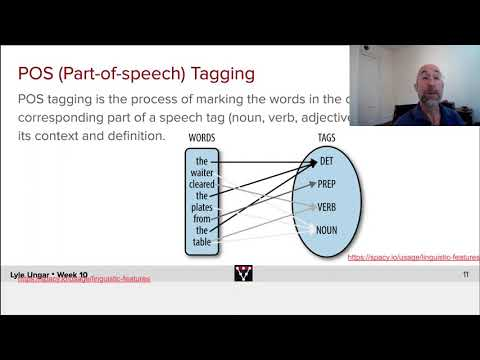

In [7]:
#@title Video : NLP  Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="vzsDA8qazW8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

*Estimated time: 15 minutes since start*

---
##Section 1: Overview of NLP

Natural Language Processing (NLP) techniques process and analyze large amounts of natural language data. 
NLP applications include:

1.   Sentiment Analysis: Understanding the views of people/customers towards a specific product or service. 
2.   Virtual Assistants: Alexa, Siri and Google Assistant, etc.
3.   Machine Translation: Translating speech or text from one language to another.  
4.   Information retrieval and search engines
5.   Question Answering
6.   Summarization
7.   Identifying Fake News and spam: Ironically, NLP can also be used to generate fake news.

NLP is also increasingly being used in recruitment decisions, litigation tasks, etc.


Video available at https://youtube.com/watch?v=TZv5NmAjUyA


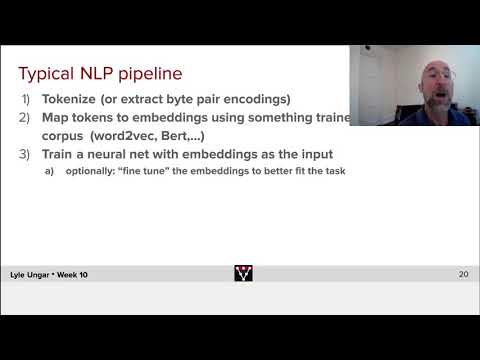

In [8]:
#@title Video : Language Processing
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="TZv5NmAjUyA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

###Question

In [9]:
#report to Airtable
#@markdown What's your favorite NLP application?  What are you most excited to learn about? Discuss with your pod!
NLP_summary = "Honestly, I am not that passionate about NLP. I think if I were to use it, it would be more for linguistic purposes and understanding writing styles, language, etc. Not that excited about \"reading\" product reviews. Actually, as another pod member pointed out, auto CC on vidoes is really neat. " #@param {type:"string"}

*Estimated time: 35 minutes since start*

---
##Section 2: Word Embeddings

Video available at https://youtube.com/watch?v=ufqGdQcwa5A


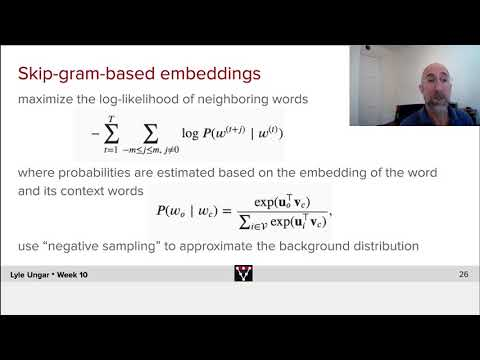

In [10]:
#@title Video : Embeddings
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ufqGdQcwa5A", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video


Words or subword units such as morphemes are the basic units that we use to express meaning  in language. The technique of mapping words to vectors of real numbers is known as word embedding. 

Last week, we saw that one-hot word vectors cannot accurately express the similarity between different words. The cosine similarity between the one-hot vectors of any two different words is zero.

This week, we will be using pretrained fastText embeddings, a context-oblivious embedding similar to word2vec. 

###Exercise 1: Embedding Manipulation

Let's use the FastText library to manipulate the embeddings. 
First, find the embedding for the word "King"

In [11]:
#@title Download FastText English Embeddings of dimension 100

# 1d2fzekxTgDIA9LEYskPXT1sfccgAGmUF
# file_id = '11qRoFOUiGnvM04ERcN_6Qn6O_dJ2KPLk'
# destination = 'cc.en.100.bin.zip'
# download_file_from_google_drive(file_id, destination)
# import os
# os.listdir('.')

# with zipfile.ZipFile('cc.en.100.bin.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

!wget -O cc.fr.100.bin.gz https://osf.io/6tqvp/download
!wget -O cc.en.100.bin.gz https://osf.io/2frqg/download


--2021-03-29 21:15:43--  https://osf.io/6tqvp/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca6421a175b009644f2c1?action=download&direct&version=1 [following]
--2021-03-29 21:15:43--  https://files.osf.io/v1/resources/6aws8/providers/osfstorage/605ca6421a175b009644f2c1?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1509233727 (1.4G) [application/octet-stream]
Saving to: ‘cc.fr.100.bin.gz’

cc.fr.100.bin.gz    100%[===================>]   1.41G  25.8MB/s    in 57s     

2021-03-29 21:16:41 (25.4 MB/s) - ‘cc.fr.100.bin.gz’ saved [1509233727/1509233727]

--2021-03-29 21:16:41--  https://osf.io/2frqg/download
Resolving osf.io (osf

In [12]:
import os
os.listdir('.')

with zipfile.ZipFile('cc.en.100.bin.gz', 'r') as zip_ref:
    zip_ref.extractall('.')

In [13]:
#####Load 100 dimension FastText Vectors using FastText library
ft_en_vectors = fasttext.load_model('cc.en.100.bin')

In [14]:
print("Length of the embedding is: ", len(ft_en_vectors.get_word_vector('king')))
print("Embedding for the word King is: ", ft_en_vectors.get_word_vector('king'))

Length of the embedding is:  100
Embedding for the word King is:  [-0.04045481 -0.10617249 -0.27222311  0.06879666  0.16408321  0.00276707
  0.27080125 -0.05805573 -0.31865698  0.03748008 -0.00254088  0.13805169
 -0.00182498 -0.08973497  0.00319015 -0.19619396 -0.09858181 -0.10103802
 -0.08279888  0.0082208   0.13119364 -0.15956607  0.17203182  0.0315701
 -0.25064597  0.06182072  0.03929246  0.05157393  0.03543638  0.13660161
  0.05473648  0.06072914 -0.04709269  0.17394426 -0.02101276 -0.11402624
 -0.24489872 -0.08576579 -0.00322696 -0.04509873 -0.00614253 -0.05772085
 -0.073414   -0.06718913 -0.06057961  0.10963406  0.1245006  -0.04819863
  0.11408057  0.11081408  0.06752145 -0.01689911 -0.01186301 -0.11716368
 -0.01287614  0.10639337 -0.04243141  0.01057278 -0.0230855  -0.04930984
  0.04717607  0.03696446  0.0015999  -0.02193867 -0.01331578  0.11102925
  0.1686794   0.05814958 -0.00296521 -0.04252011 -0.00352389  0.06267346
 -0.07747819 -0.08959802 -0.02445797 -0.08913022  0.1342223

Cosine similarity is used for similarities between words. Similarity is a scalar between 0 and 1.

Now find the 10 most similar words to "King"

In [15]:
ft_en_vectors.get_nearest_neighbors("king",10) # Most similar by key

[(0.8168574571609497, 'prince'),
 (0.796097457408905, 'emperor'),
 (0.7907207608222961, 'kings'),
 (0.7655220627784729, 'lord'),
 (0.7435404062271118, 'king-'),
 (0.7394551634788513, 'chieftain'),
 (0.7307553291320801, 'tyrant'),
 (0.7226710319519043, 'conqueror'),
 (0.719561755657196, 'kingly'),
 (0.718187689781189, 'queen')]

###Exercise 2: Word Similarity

More on similarity between words. Let's check how similar different pairs of word are. Feel free to play around.



In [47]:
def getSimilarity(word1, word2):
  v1 = ft_en_vectors.get_word_vector(word1)
  v2 = ft_en_vectors.get_word_vector(word2)
  return cosine_similarity(v1, v2)

print("Similarity between the words King and Queen: ", getSimilarity("king", "queen"))
print("Similarity between the words King and Knight: ", getSimilarity("king", "knight"))
print("Similarity between the words King and Rock: ", getSimilarity("king", "rock"))
print("Similarity between the words King and Twenty: ", getSimilarity("king", "twenty"))
print()
print("Similarity between the words Dog and Cat: ", getSimilarity("dog", "cat"))
print("Similarity between the words Ascending and Descending: ", getSimilarity("ascending", "descending"))
print("Similarity between the words Victory and Defeat: ", getSimilarity("victory", "defeat"))
print("Similarity between the words Less and More: ", getSimilarity("less", "more"))
print("Similarity between the words True and False: ", getSimilarity("true", "false"))

Similarity between the words King and Queen:  0.71818775
Similarity between the words King and Knight:  0.6881009
Similarity between the words King and Rock:  0.28928387
Similarity between the words King and Twenty:  0.19655468

Similarity between the words Dog and Cat:  0.83396447
Similarity between the words Ascending and Descending:  0.8707449
Similarity between the words Victory and Defeat:  0.7478056
Similarity between the words Less and More:  0.84619784
Similarity between the words True and False:  0.59538496


###Question

Why do you think the words with opposite meanings like "Ascending" and "Descending" or "Victory" and "Defeat" have high similarity? Discuss with your pod.

In [45]:
#report to Airtable
words_with_opposite_meanings = 'They are very similar in context but very different in meaning. This might be the reason since their context has high similarity. ' #@param {type:"string"}

Using embeddings, we can find the words that appear in similar contexts. But, what happens if the word has several different meanings? 

###Exercise 3: Homonym Similarity

Find the similarity for homonyms with their different meanings. The first one has been implemented for you.

In [ ]:
#######################     Words with multiple meanings     ##########################
print("Similarity between the words Cricket and Insect: ", getSimilarity("cricket", "insect"))
print("Similarity between the words Cricket and Sport: ", getSimilarity("cricket", "sport"))

#Try the same for two more pairs
print("Similarity between the words baseball and football: ", getSimilarity("baseball","football"))
print("Similarity between the words baseball and cricket: ", getSimilarity("baseball","cricket"))
print("Similarity between the words baseball and mouse: ", getSimilarity("baseball","mouse"))
print("Similarity between the words baseball and ball: ", getSimilarity("baseball","ball"))

print("Similarity between the words coffee and tea: ", getSimilarity("coffee","tea"))
print("Similarity between the words coffee and poop: ", getSimilarity("coffee","poop"))


###Word Analogies

Embeddings can be used to find word analogies.
Let's try it:
1.   Man : Woman  ::  King : _____
2.  Germany: Berlin :: France : ______
3.  Leaf : Tree  ::  Petal : _____





In [ ]:
## Use get_analogies() funnction. The words have to be in the order Positive, negative,  Positve

# Man : Woman  ::  King : _____
# Positive=(woman, king), Negative=(man)
print(ft_en_vectors.get_analogies("woman", "man", "king",1)) 

# Germany: Berlin :: France : ______
# Positive=(berlin, frannce), Negative=(germany)
print(ft_en_vectors.get_analogies("berlin", "germany", "france",1))

# Leaf : Tree  ::  Petal : _____
# Positive=(tree, petal), Negative=(leaf)
print(ft_en_vectors.get_analogies("tree", "leaf", "petal",1))

# Hammer : Nail  ::  Comb : _____
# Positive=(nail, comb), Negative=(hammer)
print(ft_en_vectors.get_analogies("nail", "hammer", "comb",1))

But, does it always work?


1.   Poverty : Wealth  :: Sickness : _____
2.   train : board :: horse : _____

In [ ]:
# Poverty : Wealth  :: Sickness : _____
print(ft_en_vectors.get_analogies("wealth", "poverty", "sickness",1))

# train : board :: horse : _____
print(ft_en_vectors.get_analogies("board", "train", "horse",1))

[(0.615874171257019, 'affliction')]
[(0.5437814593315125, 'bull')]


#### Question 

In [43]:
#@markdown What are the drawbacks of word embeddings? How can they be improved?
#report to Airtable
embeddings_improve = 'It seems that it cannot always infer the relationship between the words. For some +/- analogies, the second set is +/+ or -/-. It seems that similarity is weighted higher than word relationship' #@param {type:"string"}

###Section 2.1: Multilingual Embeddings

Traditionally, word embeddings have been lnaguage-specific, with embeddings for each language trained separately and existing in entirely different vector spaces. But, what if we wanted to compare words in one language to another language? Say, we want to create a text classifier with a corpus consisting of English and Spanish words. 

We use the multilingual word embeddings provided in fastText. More information can be found [here](https://engineering.fb.com/2018/01/24/ml-applications/under-the-hood-multilingual-embeddings/).

#### Training multilingual embeddings
We first train separate embeddings for each language using fastText and a combination of data from Facebook and Wikipedia. Then, we find a dictionary of common words between the two languages. The dictionaries are automatically induced from parallel data - datasets that consist of a pair of sentences in two different languages that have the same meaning. 

Then, we find a matrix that projects the embeddings into a common space between the given languages. The matrix is designed to minimize the distance between a word $x_i$ and its projection $y_i$. If our dictionary consists of pairs $(x_i, y_i)$, our projector $M$ would be: 

$$M = \text{argmin}_W\sum_i ||x_i - Wy_ii||^2$$

Also, the projector matrix $W$ is constrained to e orthogonal so that original distances between word embedding vectors are preserved. Multilingual models are trained by using our multilingual word embeddings as the base representations in DeepText and “freezing” them, or leaving them unchanged during the training process. 


After going through this, try to replicate the above exercises but in different languages! 


Video available at https://youtube.com/watch?v=cqNiEsH7Iqc


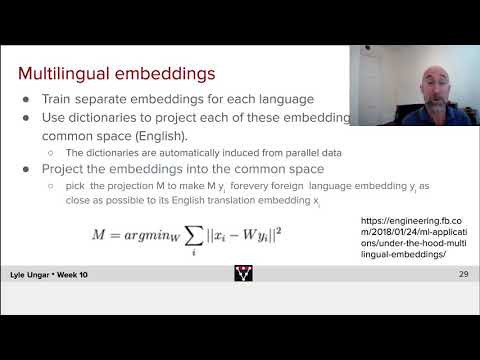

In [ ]:
#@title Video : Multilingual Embeddings
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="cqNiEsH7Iqc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

In [ ]:
#@title Download FastText French Embeddings of dimension 100

# file_id = '1-2xfEBNRBlf1tSJCEGb8EtBtnagYadd3' # French
# destination = 'cc.fr.100.bin.gz'
# download_file_from_google_drive(file_id, destination)

# with zipfile.ZipFile('cc.fr.100.bin.gz', 'r') as zip_ref:
#     zip_ref.extractall('.')

with zipfile.ZipFile('cc.fr.100.bin.gz', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
#####Load 100 dimension FastText Vectors using FastText library
french = fasttext.load_model('cc.fr.100.bin')

First, we take a look at the cosine similarity between different languages without projecting them into the same vector space. As you can see, the same words seem to be close to $0$ cosine similarity in different languages - so neither similar nor dissimilar. 

In [ ]:
hello = ft_en_vectors.get_word_vector('hello')
hi = ft_en_vectors.get_word_vector('hi')
bonjour = french.get_word_vector('bonjour')

print("Cosine Similarity between HI and HELLO: {}".format(cosine_similarity(hello, hi)))
print("Cosine Similarity between BONJOUR and HELLO: {}".format(cosine_similarity(hello, bonjour)))


Cosine Similarity between HI and HELLO: 0.7028388977050781
Cosine Similarity between BONJOUR and HELLO: 0.20523205399513245


In [ ]:
cat = ft_en_vectors.get_word_vector('cat')
chatte = french.get_word_vector('chatte')
chat = french.get_word_vector('chat')

print("Cosine Similarity between cat and chatte: {}".format(cosine_similarity(cat, chatte)))
print("Cosine Similarity between cat and chat: {}".format(cosine_similarity(cat, chat)))
print("Cosine Similarity between chatte and chat: {}".format(cosine_similarity(chatte, chat)))


Cosine Similarity between cat and chatte: -0.013087842613458633
Cosine Similarity between cat and chat: -0.02490561455488205
Cosine Similarity between chatte and chat: 0.6003134250640869


First, let's define a list of words that are in common between English and French. We'll be using this to make our training matrices. 

In [ ]:
en_words = set(ft_en_vectors.words)
fr_words = set(french.words)
overlap = list(en_words & fr_words)
bilingual_dictionary = [(entry, entry) for entry in overlap]

We define a few functions to make our lives a bit easier: `make_training_matrices` takes in the source words, target language words, and the set of common words. It then creates a matrix of all the word embeddings of all common words between the languages (in each language). These are our training matrices. 

The function `learn_transformation` then takes in these matrices, normalizes them, and then performs SVD, which aligns the source language to the target and returns a transformation matrix. 

In [ ]:
def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    source_matrix = []
    target_matrix = []

    for (source, target) in tqdm(bilingual_dictionary):
        #if source in source_dictionary.words and target in target_dictionary.words:
        source_matrix.append(source_dictionary.get_word_vector(source))
        target_matrix.append(target_dictionary.get_word_vector(target))

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

Now, we just have to put it all together! 

In [ ]:
source_training_matrix, target_training_matrix = make_training_matrices(ft_en_vectors, french, bilingual_dictionary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
transform = learn_transformation(source_training_matrix, target_training_matrix)

Let's run the same examples as above, but this time, whenever we use French words, matrix multiply the embedding by the transpose of the transform matrix. That works a lot better! 

In [ ]:
hello = ft_en_vectors.get_word_vector('hello')
hi = ft_en_vectors.get_word_vector('hi')
bonjour = np.matmul(french.get_word_vector('bonjour'), transform.T)

print("Cosine Similarity between HI and HELLO: {}".format(cosine_similarity(hello, hi)))
print("Cosine Similarity between BONJOUR and HELLO: {}".format(cosine_similarity(hello, bonjour)))


Cosine Similarity between HI and HELLO: 0.7028388977050781
Cosine Similarity between BONJOUR and HELLO: 0.5818603038787842


In [ ]:
cat = ft_en_vectors.get_word_vector('cat')
chatte = np.matmul(french.get_word_vector('chatte'), transform.T)
chat = np.matmul(french.get_word_vector('chat'), transform.T)

print("Cosine Similarity between cat and chatte: {}".format(cosine_similarity(cat, chatte)))
print("Cosine Similarity between cat and chat: {}".format(cosine_similarity(cat, chat)))
print("Cosine Similarity between chatte and chat: {}".format(cosine_similarity(chatte, chat)))


Cosine Similarity between cat and chatte: 0.4327276349067688
Cosine Similarity between cat and chat: 0.6866637468338013
Cosine Similarity between chatte and chat: 0.6003133654594421


Now, try a couple of your own examples. Try some of the examples you looked at in $2.1$, but with English and French. Does it work as expected? 

In [ ]:
# USE THIS SPACE TO TRY YOUR OWN EXAMPLES

In [ ]:
#@markdown Clean Up of Previous Files (MUST RUN)
!rm cc.fr.100.bin.gz
!rm cc.en.100.bin
!rm cc.fr.100.bin

*Estimated time: 50 minutes since start*

---
##Section 3: Neural Net with word embeddings

Video available at https://youtube.com/watch?v=skFimcn320U


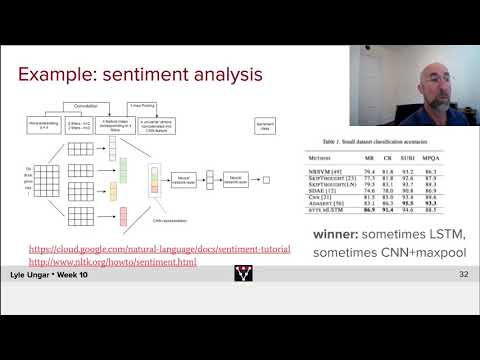

In [21]:
#@title Sentence Embeddings
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="skFimcn320U", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

As we saw last week, training context-oblivious word embeddings is relatively cheap, but most people still use pre-trained word embeddings. After we cover context sensitive word embeddings we'll see how to "fine tune" embeddings (adjust them to the task at hand).

Let's use the pretrained FastText embeddings to train a neural network on the IMDB dataset from previous week. 

To recap, the data consists of reviews and sentiments attached to it. It is a binary classification task. Last week we achieved an accuracy of about **70\%** on the Test data with LSTM network and around **65%** on the Vanilla RNN network.




###Exercise 4: Simple feed forward net

In [22]:
#@title Download embeddings (Run while watching above video)

embedding_fasttext = FastText('simple')

.vector_cache/wiki.simple.vec: 293MB [00:15, 19.2MB/s]                           
 99%|█████████▉| 110091/111051 [00:10<00:00, 10604.43it/s]

This will load 300 dim FastText embeddings. It will take around 2-3 minutes.

Define a vanilla neural network with linear layers. Then average the word embeddings to get an embedding for the entire review.
The neural net will have one hidden layer of size 128.

In [23]:
class NeuralNet(nn.Module):
  def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
    super(NeuralNet, self).__init__()

    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, inputs):
    
    input = self.word_embeddings(inputs) #convert text to embeddings
    ####################################################################
    # Fill in missing code below (...)
    # raise NotImplementedError("Fill in the Neural Net")
    
    #Average the word embedddings in a sentence
    #Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = F.avg_pool2d(input,kernel_size=(input.shape[1], 1)).squeeze(1)

    #Pass the embeddings through the neural net
    x = self.fc1(pooled)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)    
    return output

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W10_NLP/solutions/W10_Tutorial1_Solution_Ex01.py)

In [29]:
#@title Training and Testing Functions

def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
      #train
      model.train()
      running_loss = 0.
      correct, total = 0, 0 
      steps = 0

      for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        # add micro for coding training loop
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        steps += 1
        running_loss += loss.item()

        # get accuracy 
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
      train_loss.append(running_loss/len(train_iter))
      train_acc.append(correct/total)

      print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0 

      with torch.no_grad():
        for idx, batch in enumerate(valid_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(text)
    
            loss = criterion(output, target)
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(valid_iter))
      validation_acc.append(correct/total)

      print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}%')
  
    return train_loss, train_acc, validation_loss, validation_acc

def test(model,  device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        outputs = model(text)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

In [32]:
##Load the Dataset
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(embedding_fasttext)


aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz



aclImdb_v1.tar.gz:   0%|          | 49.2k/84.1M [00:00<03:57, 353kB/s]
aclImdb_v1.tar.gz:   0%|          | 98.3k/84.1M [00:00<04:01, 348kB/s]
aclImdb_v1.tar.gz:   0%|          | 213k/84.1M [00:00<03:21, 417kB/s] 
aclImdb_v1.tar.gz:   0%|          | 377k/84.1M [00:00<02:43, 513kB/s]
aclImdb_v1.tar.gz:   1%|          | 655k/84.1M [00:00<02:07, 656kB/s]
aclImdb_v1.tar.gz:   1%|          | 1.03M/84.1M [00:00<01:38, 845kB/s]
aclImdb_v1.tar.gz:   2%|▏         | 1.52M/84.1M [00:01<01:15, 1.09MB/s]
aclImdb_v1.tar.gz:   3%|▎         | 2.23M/84.1M [00:01<00:57, 1.42MB/s]
aclImdb_v1.tar.gz:   4%|▍         | 3.36M/84.1M [00:01<00:43, 1.87MB/s]
aclImdb_v1.tar.gz:   6%|▌         | 5.05M/84.1M [00:01<00:31, 2.49MB/s]
aclImdb_v1.tar.gz:   9%|▊         | 7.27M/84.1M [00:01<00:23, 3.34MB/s]
aclImdb_v1.tar.gz:  11%|█         | 9.24M/84.1M [00:01<00:16, 4.45MB/s]
aclImdb_v1.tar.gz:  15%|█▍        | 12.2M/84.1M [00:01<00:12, 5.89MB/s]
aclImdb_v1.tar.gz:  18%|█▊        | 15.3M/84.1M [00:01<00:08, 7.79MB/s]

In [33]:
learning_rate = 0.0003
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300
epochs = 15
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)


nn_model = NeuralNet(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
nn_model.to(device)
nn_start_time = time.time()
nn_train_loss, nn_train_acc, nn_validation_loss, nn_validation_acc = train(nn_model, device, train_iter, valid_iter, epochs, learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - nn_start_time))
test_accuracy = test(nn_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%')

Epoch: 1,  Training Loss: 0.6676, Training Accuracy:  59.78%
Validation Loss: 0.6436, Validation Accuracy:  64.16%
Epoch: 2,  Training Loss: 0.6254, Training Accuracy:  65.93%
Validation Loss: 0.6106, Validation Accuracy:  67.76%
Epoch: 3,  Training Loss: 0.6012, Training Accuracy:  68.02%
Validation Loss: 0.5948, Validation Accuracy:  68.59%
Epoch: 4,  Training Loss: 0.5919, Training Accuracy:  68.72%
Validation Loss: 0.5870, Validation Accuracy:  69.23%
Epoch: 5,  Training Loss: 0.5839, Training Accuracy:  69.67%
Validation Loss: 0.5819, Validation Accuracy:  69.36%
Epoch: 6,  Training Loss: 0.5829, Training Accuracy:  69.55%
Validation Loss: 0.6172, Validation Accuracy:  65.95%
Epoch: 7,  Training Loss: 0.5798, Training Accuracy:  69.51%
Validation Loss: 0.5773, Validation Accuracy:  69.95%
Epoch: 8,  Training Loss: 0.5752, Training Accuracy:  70.02%
Validation Loss: 0.5772, Validation Accuracy:  70.13%
Epoch: 9,  Training Loss: 0.5738, Training Accuracy:  70.13%
Validation Loss: 0.

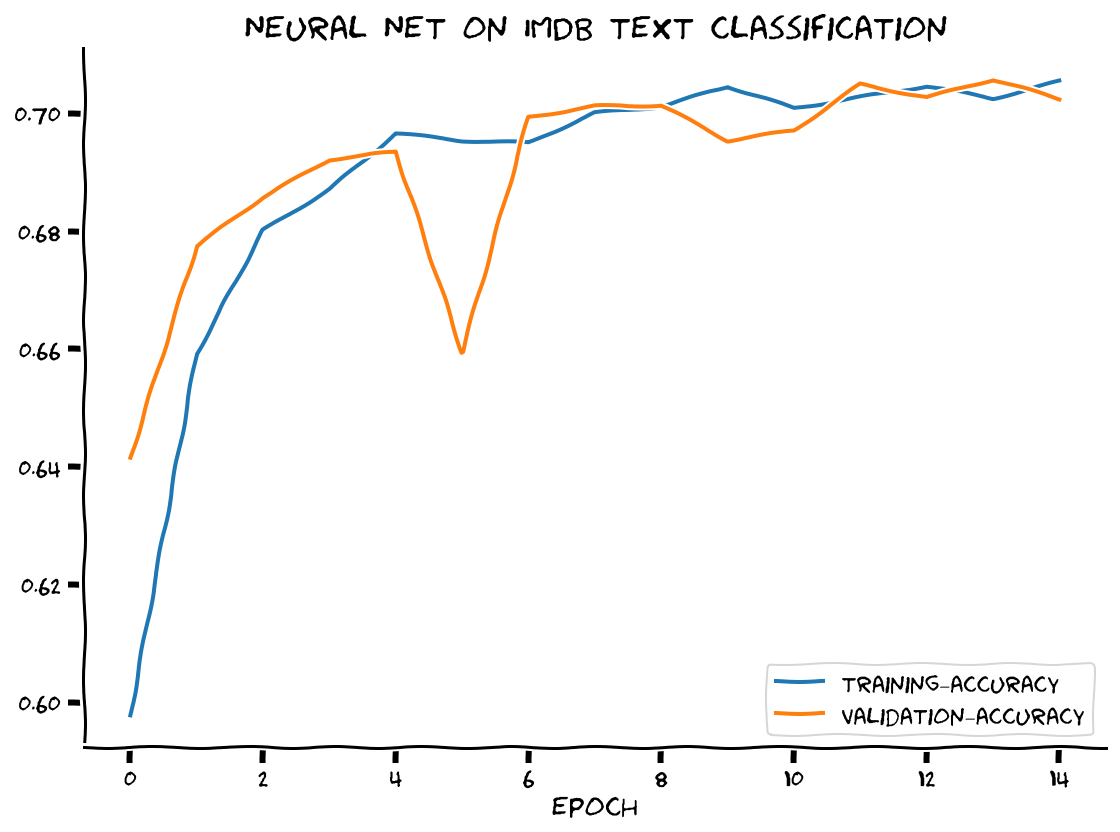

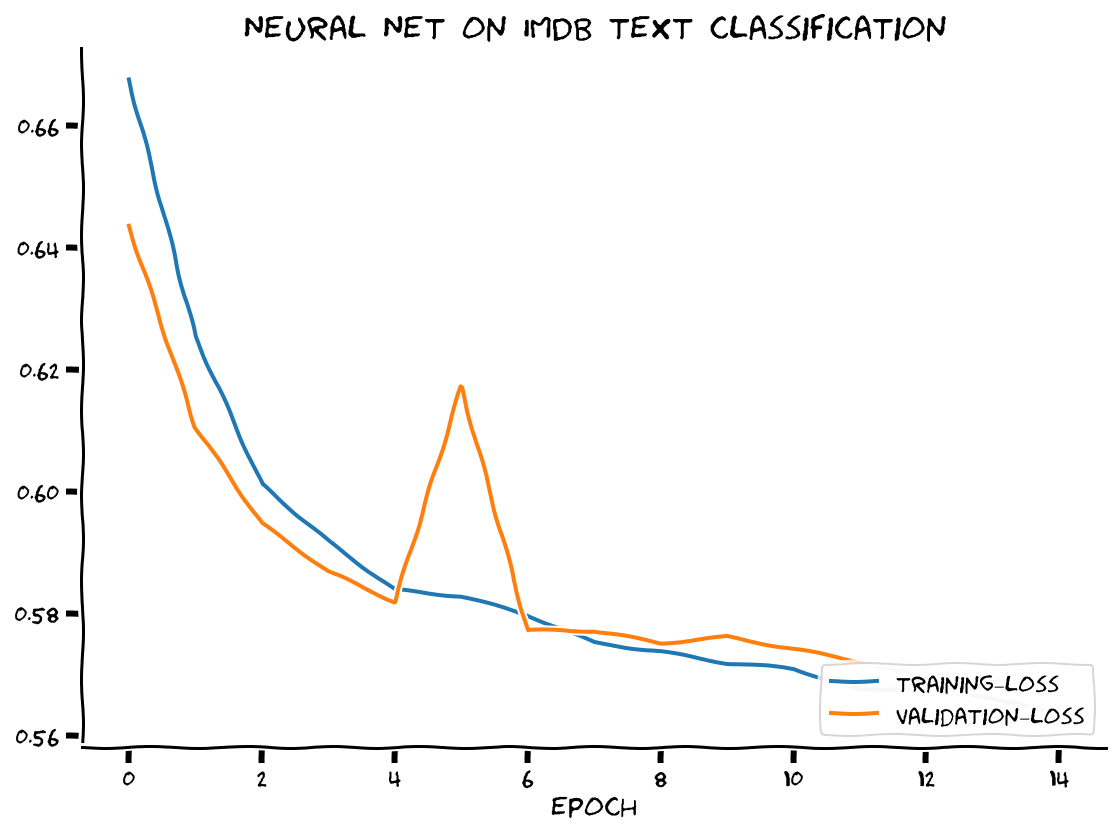

In [34]:
with plt.xkcd():
    plot_train_val(np.arange(0,epochs), nn_train_acc, nn_validation_acc,
                   'training_accuracy', 'validation_accuracy', 'Neural Net on IMDB text classification')

with plt.xkcd():
    plot_train_val(np.arange(0,epochs), nn_train_loss, nn_validation_loss,
                   'training_loss', 'validation_loss', 'Neural Net on IMDB text classification')

In [35]:
#@markdown Did the neural network perform better or worse than the LSTM from previous week? Why do you think they did so?
nn_net_performance = 'It performed worse but still quite well considering that it is a a linear network not an LSTM.' #@param {type:"string"}

###Exercise 5: LSTM

Averaging out the embeddings neglects the sequence of the words in the reviews.
For example, consider two sentences:

1. our president is a good leader he will not fail 
2. our president is not a good leader he will fail.

Both the sentences will have the same average embeddings. Hence, it is always not a good idea to average the embeddings.

Let's implement an LSTM for the same embeddings, similar to what we did last week.

We will use similar architecture as the previous week: an LSTM with 2 layers. 

In [36]:
class LSTM(nn.Module):
  def __init__(self, layers, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
    super(LSTM, self).__init__()

    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length
    self.n_layers = layers

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=True)
    self.lstm = nn.LSTM(embedding_length, hidden_size, num_layers = self.n_layers)
    self.fc1 = nn.Linear(self.n_layers*self.hidden_size, output_size)

  def forward(self, input_sentences, batch_size=None):

    ####################################################################
    # Fill in missing code below (...)
    # raise NotImplementedError("perform the convolution")

    ### Get the word embeddings of the text
    ### initialize the hidden layers
    ### Pass the embeddinngs through lstm

    # `input` shape: (`num_steps`, `batch_size`, `num_hiddens`)
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    
    # Initialize a random hidden state and cell state for this sequence
    hidden = (torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device),
            torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device))
    
    # LSTM 
    output, (hidden,cell)= self.lstm(input,hidden)
  
    # Pick the hidden state (not cell state) and reshape it for the linear layer
    h_n = hidden.permute(1, 0, 2)    
    h_n = h_n.contiguous().view(h_n.shape[0], -1)

    #pass it through the fully connected layers fc1
    lstm_output =  self.fc1(h_n)

    return lstm_output

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W10_NLP/solutions/W10_Tutorial1_Solution_Ex02.py)

In [37]:
learning_rate = 0.0003
batch_size = 32
output_size = 2
hidden_size = 32
embedding_length = 300
epochs = 20
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)
layers = 2

lstm_model = LSTM(layers, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
lstm_model.to(device)
lstm_start_time = time.time()
lstm_train_loss, lstm_train_acc, lstm_validation_loss, lstm_validation_acc = train(lstm_model, device, train_iter, valid_iter, epochs, learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - lstm_start_time))
test_accuracy = test(lstm_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%')

Epoch: 1,  Training Loss: 0.6625, Training Accuracy:  59.61%
Validation Loss: 0.6030, Validation Accuracy:  68.25%
Epoch: 2,  Training Loss: 0.5032, Training Accuracy:  76.06%
Validation Loss: 0.5209, Validation Accuracy:  74.59%
Epoch: 3,  Training Loss: 0.3527, Training Accuracy:  85.05%
Validation Loss: 0.5297, Validation Accuracy:  73.80%
Epoch: 4,  Training Loss: 0.2414, Training Accuracy:  90.57%
Validation Loss: 0.6043, Validation Accuracy:  75.75%
Epoch: 5,  Training Loss: 0.1540, Training Accuracy:  94.49%
Validation Loss: 0.7315, Validation Accuracy:  74.28%
Epoch: 6,  Training Loss: 0.1008, Training Accuracy:  96.51%
Validation Loss: 0.9034, Validation Accuracy:  72.05%
Epoch: 7,  Training Loss: 0.0636, Training Accuracy:  97.97%
Validation Loss: 1.0133, Validation Accuracy:  72.96%
Epoch: 8,  Training Loss: 0.0398, Training Accuracy:  98.81%
Validation Loss: 1.0944, Validation Accuracy:  72.04%
Epoch: 9,  Training Loss: 0.0332, Training Accuracy:  98.90%
Validation Loss: 1.

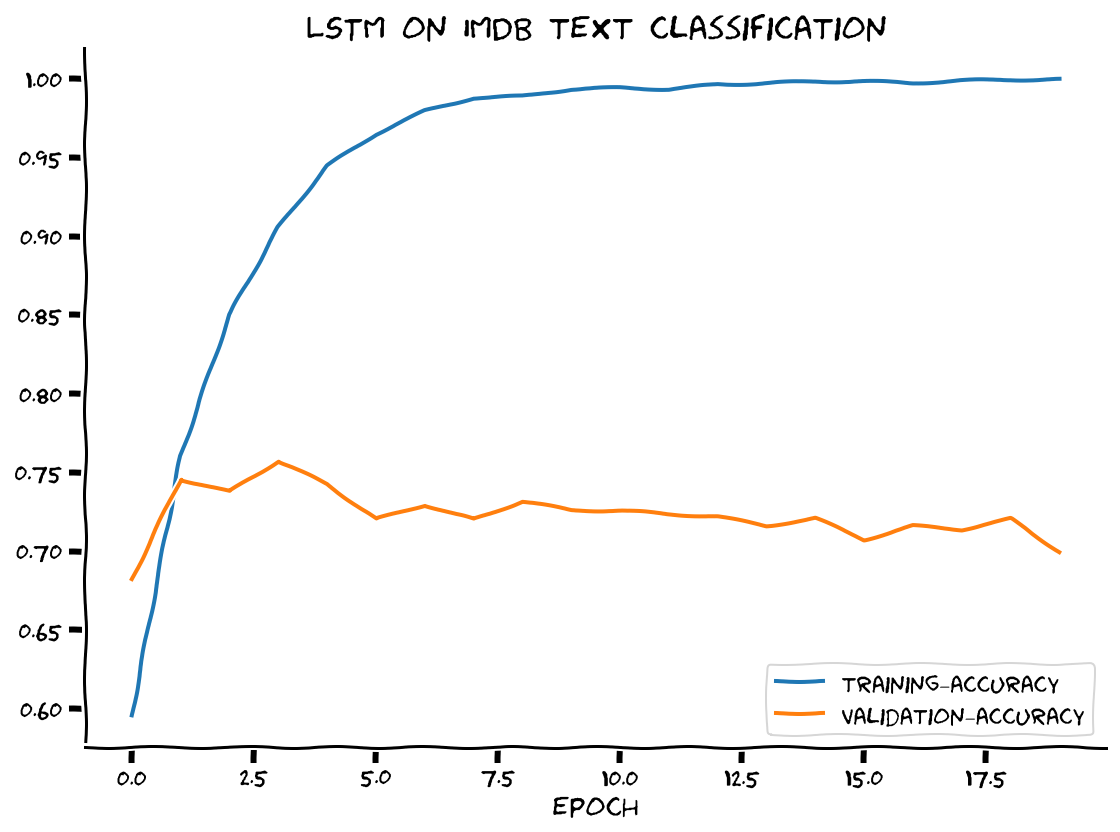

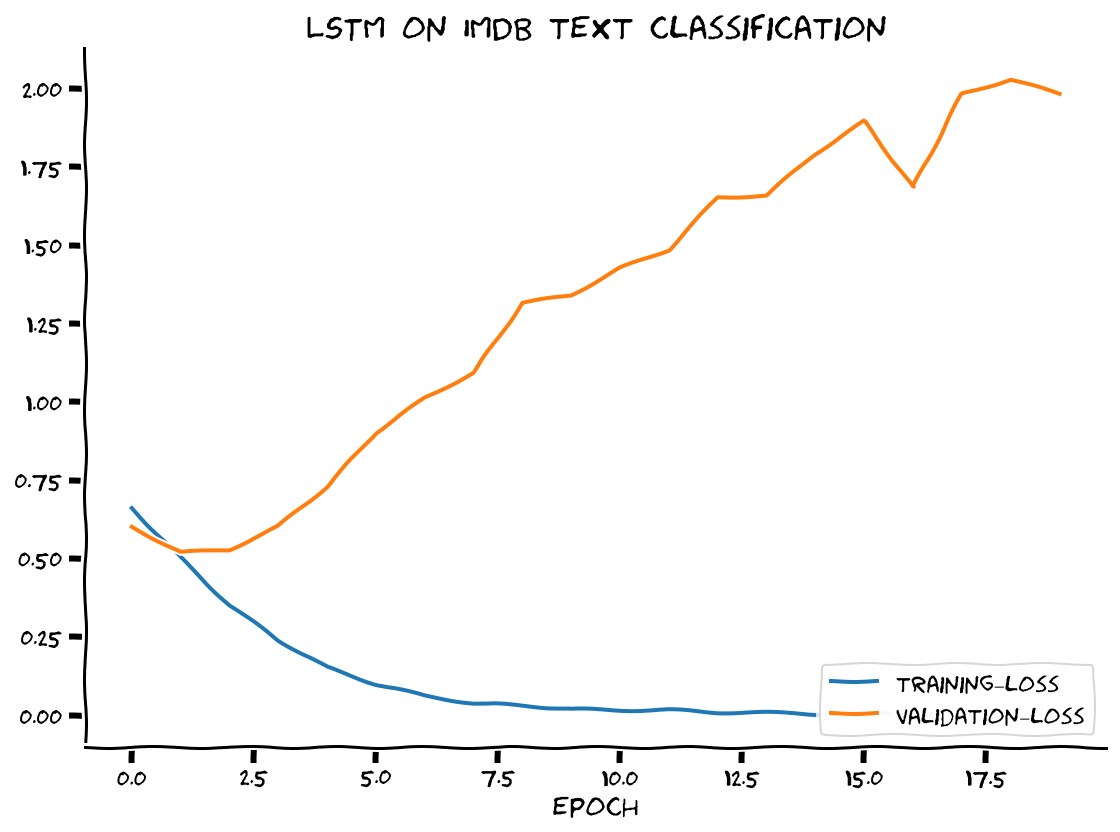

In [38]:
with plt.xkcd():
    plot_train_val(np.arange(0,epochs), lstm_train_acc, lstm_validation_acc,
                   'training_accuracy', 'validation_accuracy', 'LSTM on IMDB text classification')

with plt.xkcd():
    plot_train_val(np.arange(0,epochs), lstm_train_loss, lstm_validation_loss,
                   'training_loss', 'validation_loss', 'LSTM on IMDB text classification')

*Estimated time: 80 minutes since start*

---
##Section 4: Attention

Video available at https://youtube.com/watch?v=VY2Ewm45tO4


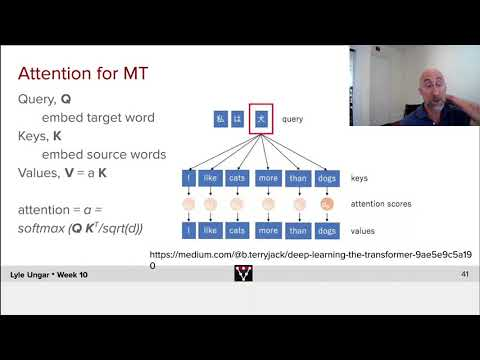

In [ ]:
#@title Video : Attention
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="VY2Ewm45tO4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

Reference Links: \\
 https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/ \\

 https://d2l.ai/chapter_attention-mechanisms/attention-cues.html
 

Last week, we designed an encoder-decoder architecture based on two RNNs for sequence to sequence learning. Specifically, the RNN encoder transforms a variable-length sequence into a fixed-shape context variable, then the RNN decoder generates the output (target) sequence token by token based on the generated tokens and the context variable. However, even though not all the input (source) tokens are useful for decoding a certain token, the same context variable that encodes the entire input sequence is still used at each decoding step. It is challenging for the models to deal with long sentences. 

In [Bahdanau et al., 2014], the authors proposed a technique called attention. When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to parts of the input sequence that are relevant to the current prediction. 


<figure>
    <center><img src=https://jalammar.github.io/images/seq2seq_7.mp4>
    <figcaption> Sequence to Sequence model with Attention </figcaption>
    </center>    
</figure>



In [17]:
#@title Run this if above link is broken

url = "https://jalammar.github.io/images/seq2seq_7.mp4"
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")

In contrast to seq2seq model, the encoder passes a lot more data to the decoder. Instead of passing the last hidden state of the encoding stage, the encoder passes all the hidden states to the decoder. 

In order to focus on the parts of input relevant to the decoder, look at the set of encoder hidden states it received. Each encoder hidden state is at most associated with a certain word in the input sentence. We can assign each hidden state a score and multiply it with the softmaxed score, thus amplifying hidden states with high scores, and drowning out hidden states with low scores.

<figure>
    <center><img src=https://jalammar.github.io/images/seq2seq_9.mp4>
    <figcaption> Mapping input to output </figcaption>
    </center>    
</figure>

<!-- <video width="320" height="240" controls>
      <source src="https://jalammar.github.io/images/seq2seq_9.mp4" type="video/mp4">
</video> -->

In [ ]:
#@title Run this if above link is broken

url = "https://jalammar.github.io/images/seq2seq_9.mp4"
from IPython.display import HTML
HTML(f"""<video src={url} width=1000 controls/>""")

###Queries, Keys, and Values



To calculate the attention mechanism we make use of Queries, Keys and Values. But what are Queries, Keys and Values? Query, Value and Key are the transformations of the input vector. 

In an attention mechanism the context vector is computed as a weighted sum of values, where the weight assigned to each value is computed through an attention score. The score is usually the dot product between the query and key. The scores then go through the softmax function to yield a set of weights whose sum equals 1.

The query is from the decoder hidden state whereas the key and value are from the encoder hidden state. 


Take a minute and look at this article. It has detailed graphical explanation on how to calculate attention scores. 
https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

### Exercise 6: Attention for Text Classification


Until now, we looked at attention aimed at seq2seq networks. Let’s try implementing attention for the above IMDB sentiment analysis dataset. Previously, using the LSTM, the classification completely depended on the last hidden state. In this exercise, we will compute the attention scores between the last hidden state and output of each sequence. The final attention vector will be the weighted average of the outputs at each sequence, with the weights being the attention scores. Lastly, we will concatenate the attention vector and the last hidden state to get the final output.

For simplicity's sake, let's implement attention over an LSTM with 1 layer.

In [39]:
#Code reference: https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/main.py

class AttentionModel(torch.nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
        super(AttentionModel, self).__init__()

        
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
        self.lstm = nn.LSTM(embedding_length, hidden_size)
        self.fc1 = nn.Linear(2*hidden_size, output_size)
        
    def attention_net(self, lstm_output, final_state):

        #Implement the attenion net
        # Fill in missing code below (...)
        # raise NotImplementedError("perform the convolution")

        """ 
        lstm_output : shape: (num_seq, batch_size, hidden_size)
        final_state : shape: (1, batch_size, hidden_size)
        """

        # permute the output to get the shape (batch_size, num_seq, hidden_size)
        # Get the attention weights 
        # use torch.bmm to compute the attention weights between each output and hast hidden state
        # pay attention to the tensor shapes, you may have to use squeeze and unsqueeze functions
        # softmax the attention weights
        # Get the new hidden state, use torch.bmm to get the weighted lstm output
        # pay attention to the tensor shapes, you may have to use squeeze and unsqueeze functions

        lstm_output = lstm_output.permute(1,0,2) 
        hidden = final_state.squeeze(0) 
        attn_weights = torch.bmm(lstm_output,hidden.unsqueeze(2)).squeeze(2)     #expected shape: (batch_size, num_seq)
        soft_attn_weights = F.softmax(attn_weights,1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1,2),soft_attn_weights.unsqueeze(2)).squeeze(2)
        
        return new_hidden_state
    
    def forward(self, input_sentences):

      input = self.word_embeddings(input_sentences)
      input = input.permute(1, 0, 2)

      h_0 = Variable(torch.zeros(1, input.shape[1], self.hidden_size).cuda())
      c_0 = Variable(torch.zeros(1, input.shape[1], self.hidden_size).cuda())

      output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
      attn_output = self.attention_net(output, final_hidden_state)
      final_output = torch.cat((attn_output, final_hidden_state[0]), 1)
      logits = self.fc1(final_output)
          
      return logits



[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W10_NLP/solutions/W10_Tutorial1_Solution_Ex03.py)

In [40]:
learning_rate = 0.0001
batch_size = 32
output_size = 2
hidden_size = 16
embedding_length = 300
epochs = 12
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)

attention_model = AttentionModel(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
attention_model.to(device)
attention_start_time = time.time()
attention_train_loss, attention_train_acc, attention_validation_loss, attention_validation_acc = train(attention_model, device, train_iter, valid_iter, epochs, learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - attention_start_time))
test_accuracy = test(attention_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%')

Epoch: 1,  Training Loss: 0.6938, Training Accuracy:  52.05%
Validation Loss: 0.6912, Validation Accuracy:  53.77%
Epoch: 2,  Training Loss: 0.6824, Training Accuracy:  56.75%
Validation Loss: 0.6845, Validation Accuracy:  56.32%
Epoch: 3,  Training Loss: 0.6712, Training Accuracy:  60.10%
Validation Loss: 0.6772, Validation Accuracy:  58.08%
Epoch: 4,  Training Loss: 0.6574, Training Accuracy:  62.99%
Validation Loss: 0.6685, Validation Accuracy:  59.52%
Epoch: 5,  Training Loss: 0.6389, Training Accuracy:  66.05%
Validation Loss: 0.6580, Validation Accuracy:  61.25%
Epoch: 6,  Training Loss: 0.6152, Training Accuracy:  68.78%
Validation Loss: 0.6474, Validation Accuracy:  62.60%
Epoch: 7,  Training Loss: 0.5854, Training Accuracy:  71.39%
Validation Loss: 0.6327, Validation Accuracy:  64.72%
Epoch: 8,  Training Loss: 0.5476, Training Accuracy:  74.50%
Validation Loss: 0.6174, Validation Accuracy:  66.52%
Epoch: 9,  Training Loss: 0.5031, Training Accuracy:  77.43%
Validation Loss: 0.

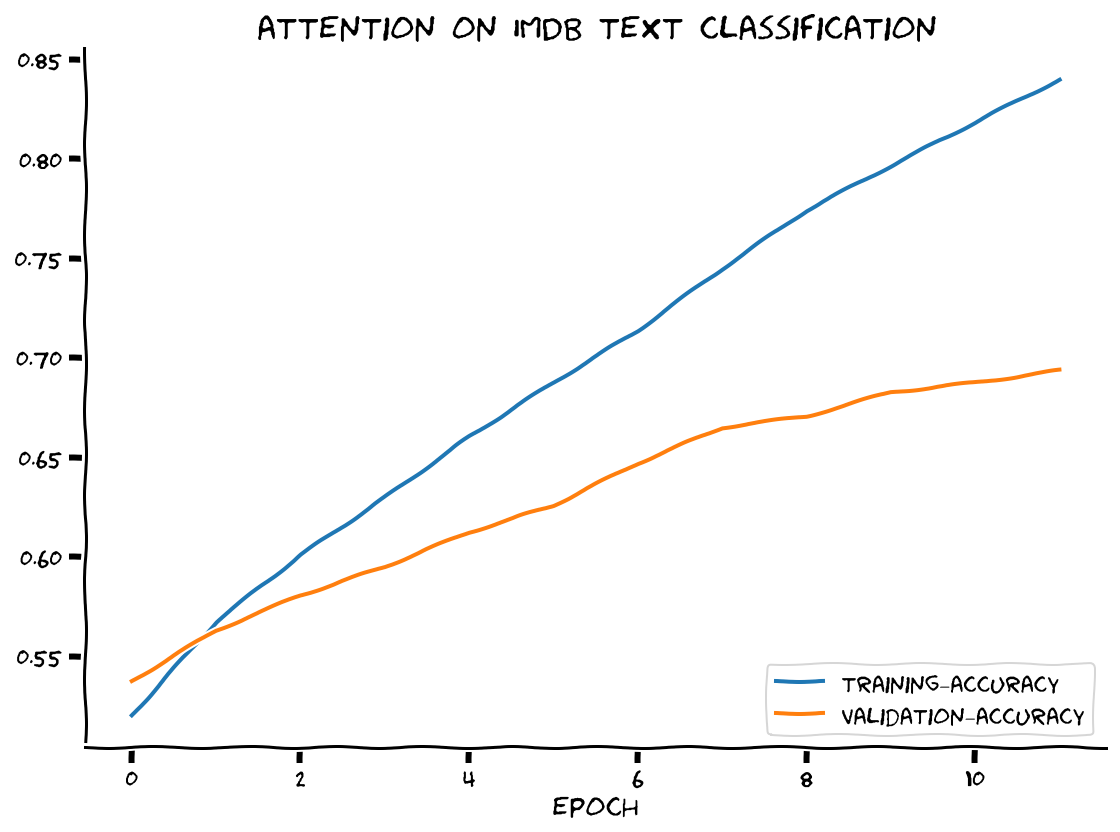

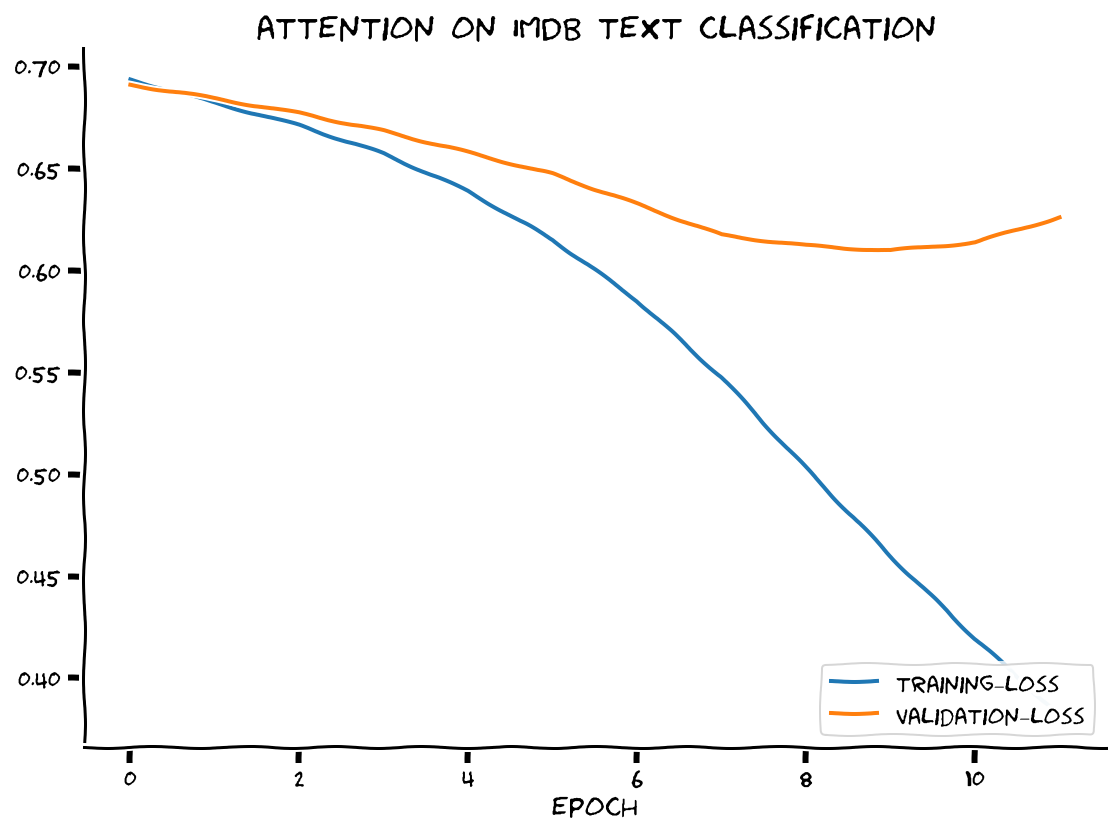

In [41]:
with plt.xkcd():
    plot_train_val(np.arange(0,epochs), attention_train_acc, attention_validation_acc,
                   'training_accuracy', 'validation_accuracy', 'attention on IMDB text classification')

with plt.xkcd():
    plot_train_val(np.arange(0,epochs), attention_train_loss, attention_validation_loss,
                   'training_loss', 'validation_loss', 'attention on IMDB text classification')

*Estimated time: 120 minutes since start*

---
# Wrap up


In [48]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()
try: t7;
except NameError: t7 = time.time()

# autofill fields if they are not present
# a missing pennkey and pod will result in an Airtable warning
# which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: last_week_recap;
except NameError: last_week_recap = "" 
try: NLP_summary;
except NameError: NLP_summary = "" 
try: words_with_opposite_meanings;
except NameError: words_with_opposite_meanings = "" 
try: embeddings_improve;
except NameError: embeddings_improve = "" 
try: nn_net_performance;
except NameError: nn_net_performance = "" 

times = np.array([t1,t2,t3,t4,t5,t6,t7])-t0

fields = {
    "my_pennkey": my_pennkey,
    "my_pod": my_pod, 
    "last_week_recap": last_week_recap,
    "NLP_summary": NLP_summary,
    "words_with_opposite_meanings": words_with_opposite_meanings,
    "embeddings_improve": embeddings_improve,
    "nn_net_performance": nn_net_performance,
    "cumulative_times": times
}

src = "https://airtable.com/embed/shrP3tKTTavRNizNY?"

display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [ ]:
display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))